# DS5559 Naive Bayes Wine Reviews v3 GOOD

## Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

##  Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_B = .1
    qntile_A = .9
    n_sets = 4
    smooth_alpha = .01
    binary_counts = True
params =  Params()

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

## Pragmas

In [3]:
%matplotlib inline

# Process

## Import wine reviews

In [4]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Convert scores to labels

### Keep only reviews with high and low ratings

In [6]:
bound_A = int(docs.points.quantile(params.qntile_A))
bound_B = int(docs.points.quantile(params.qntile_B))
docs = docs[(docs.points <= bound_B) | (docs.points >= bound_A)]

In [7]:
docs.head()

,doc_content,points
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83
337,"An easy and inviting selection, there's a ment...",83
338,The wine is earthy and somewhat rustic. There ...,82
339,"Red in color, with berry and apple aromas, thi...",82
340,"The nose is muted, despite the slight spritz o...",82


### Assign labels for high and low

In [8]:
docs.loc[docs.points >= bound_A, 'doc_label'] = 'A'
docs.loc[docs.points <= bound_B, 'doc_label'] = 'B'

In [9]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,B
337,"An easy and inviting selection, there's a ment...",83,B
338,The wine is earthy and somewhat rustic. There ...,82,B
339,"Red in color, with berry and apple aromas, thi...",82,B
340,"The nose is muted, despite the slight spritz o...",82,B


## Divide docs into train and test sets

### Assign random numbers to docs

In [10]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

In [11]:
docs.sample(5)

,doc_content,points,doc_label,set
doc_id,,,,
31689,"The namesake comedy may have its fans, but thi...",82,B,3
25875,This simple Chardonnay is tropical fruit drive...,84,B,2
30640,Light mouthfeel to this cinnamon- and herb-fla...,84,B,1
92449,"Good price, but the wine is green and unripe, ...",80,B,0
32776,"Now definitely mature, even drying up, this wi...",84,B,0


### Split docs by assigned number 

In [12]:
def split_docs(docs, n_sets=10, train_set=0, set_col='set'):
    docs.loc[docs[set_col] == train_set, 'training'] = 1
    docs['training'] = docs['training'].fillna(0).astype('int')
    return docs

In [13]:
docs = split_docs(docs, params.n_sets)

In [14]:
docs.sample(5)

,doc_content,points,doc_label,set,training
doc_id,,,,,
60721,"This is a soft wine, light and fresh. It has a...",84,B,1,0
125308,Here's a home run from one of the best produce...,94,A,2,0
86536,Smells a little too much like nail polish and ...,83,B,0,1
107745,Summus is a beautiful Tuscan blend of Sangiove...,94,A,0,1
118076,"Full and ripe, with a hint of toast, this wine...",93,A,3,0


In [15]:
TRAINING = docs.training == 1
TESTING = docs.training== 0

## Estimate class priors $p(c)$

In [16]:
Nc = docs.loc[TRAINING, 'doc_label'].value_counts()
N = len(docs.loc[TRAINING])
class_priors = Nc / N

In [17]:
np.round(class_priors, 2)

A    0.5
B    0.5
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

### Convert priors to logs

In [18]:
class_priors_log = log(class_priors)

In [19]:
np.round(class_priors_log)

A   -1.0
B   -1.0
Name: doc_label, dtype: float64

## Convert docs to tokens

In [20]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')

### Collapse tokens 

We don't need sentences, so we collapse our table to document bags.

In [21]:
tokens = tokens.groupby(['doc_id','term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})

In [22]:
tokens.head()

n
doc_id term_id   
336    1107     1
       1374     1
       1732     1
       1750     1
       2256     1

## Transfer doc labels and splits to tokens

In [23]:
tokens = tokens.join(docs[['doc_label','training']], on='doc_id', how='left')

In [24]:
tokens.head()

n doc_label  training
doc_id term_id                       
336    1107     1         B         1
       1374     1         B         1
       1732     1         B         1
       1750     1         B         1
       2256     1         B         1

## Estimate likelihoods $p(w|c)$

In [25]:
class_likelihoods = tokens[tokens.training==1].groupby(['term_id','doc_label']).n.count().unstack().fillna(0)
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [26]:
class_likelihoods.head()

doc_label,A,B
term_id,,
379,0.000011,1.804449e-07
381,0.000011,1.804449e-07
385,0.000011,1.804449e-07
388,0.000022,1.804449e-07
392,0.000108,1.804449e-07


### Convert likelihoods to logs

In [27]:
class_likelihoods_log = log(class_likelihoods)

In [28]:
class_likelihoods_log.head()

doc_label,A,B
term_id,,
379,-16.481290,-22.401938
381,-16.481290,-22.401938
385,-16.481290,-22.401938
388,-15.488450,-22.401938
392,-13.172275,-22.401938


## Add likelihood columns to test tokens table

In [29]:
testing_tokens = tokens[tokens.training==0]

In [30]:
testing_tokens = testing_tokens.join(class_likelihoods_log[['A','B']], on='term_id', how='left')

In [31]:
testing_tokens.head()

n doc_label  training          A          B
doc_id term_id                                             
340    4549     1         B         0 -10.910382 -10.365421
       5521     1         B         0 -12.246959 -12.434712
       5768     1         B         0 -12.172996 -13.754480
       10307    1         B         0 -23.139502 -12.056533
       10570    1         B         0  -7.812616  -7.250248

In [32]:
docs.loc[TESTING, 'prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['A','B']].sum())\
    .apply(lambda x: x + class_priors, 1)\
    .idxmax(1)

In [33]:
docs.loc[TESTING].head()

,doc_content,points,doc_label,set,training,prediction
doc_id,,,,,,
340,"The nose is muted, despite the slight spritz o...",82,B,3,0,B
341,"Plummy and hinting at black cherry, this wine ...",82,B,2,0,B
343,"Jumpy on the nose at first, but then green tea...",81,B,2,0,B
345,This wine contains some material over 100 year...,100,A,2,0,A
346,"This deep brown wine smells like a damp, mossy...",98,A,1,0,A


## Show results

In [38]:
docs.loc[TESTING, 'result'] = docs.loc[TESTING].doc_label == docs.loc[TESTING].prediction

In [40]:
docs.loc[TESTING].result.head()

doc_id
340    True
341    True
343    True
345    True
346    True
Name: result, dtype: object

In [43]:
CM = docs.loc[TESTING].reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [44]:
CM

doc_label,A,B
prediction,,
A,8968,621
B,145,8405


```bash
AA | 11 | true positive  | TP | "hit," "power"                     
BB | 00 | true negative  | TN | "correct rejection"            
AB | 10 | false positive | FP | "false alarm," "Type I error"  
BA | 01 | false negative | FN | "miss," "Type II error"       
```

In [45]:
def get_results(CM):
    class Results():
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        ACC = T / ALL # Accuracy
        TPR = TP / (TP + FN) # Recall, Sensitivity
        TNR = TN / (TN + FP) # Specificity
        PPV = TP / (TP + FP)  # Precision
        BA = (TNR + TPR) / 2 # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1
    return Results()

In [46]:
R = get_results(CM)

In [47]:
assert R.ALL == CM.sum().sum()

In [48]:
R.TP, R.FP, R.TN, R.FN, R.T, R.F, R.ALL

(8968, 621, 8405, 145, 17373, 766, 18139)

### Sensitivity

sensitivity, recall, hit rate, or true positive rate (TPR)

In IR, the probability that a (randomly selected) relevant document is retrieved in a search.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/73004d7856898ebe0bb1d1acd9e87b4be39b91a2)

In [49]:
R.TPR

0.9840886645451553

### Specificity

specificity, selectivity or true negative rate (TNR)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/67c35d27c765b463c514f44b0c654b30f4a1afb0)

In [50]:
R.TNR

0.9311987591402615

### Precision

precision or positive predictive value (PPV)

In IR, the probability that a (randomly selected) retrieved document is relevant.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d854b1544fc77735d575ce0d30e34d7f1eacf707)

In [51]:
R.PPV

0.9352382938784023

### Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/be4377041f6e6226f0235bcc163db409f146090f)

In [52]:
R.ACC

0.9577705496444125

### Balanced Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4383d273906da14c55300ff47ac2e587d56da0cd)

In [53]:
R.BA

0.9576437118427084

### F1 Score

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2c1b789c877bcc32a7a317c723638b14857b7966)

In [54]:
R.F1

0.9590418137097637

### Summary of Performance

In [55]:
T1 = pd.DataFrame([(var, getattr(R, var)) for var in ['T','F','TP','FP','TN','FN','ALL']], columns=['metric','score'])\
    .set_index('metric').T

In [56]:
T2 = pd.DataFrame([(var, round(getattr(R, var),2)) for var in ['TPR','TNR','PPV','ACC','BA','F1']], columns=['metric','score'])\
    .set_index('metric').T

In [57]:
T1

metric,T,F,TP,FP,TN,FN,ALL
score,17373,766,8968,621,8405,145,18139


In [58]:
T2

metric,TPR,TNR,PPV,ACC,BA,F1
score,0.98,0.93,0.94,0.96,0.96,0.96


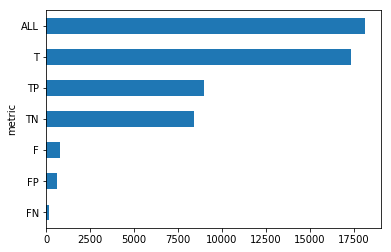

In [59]:
T1.T.sort_values('score').plot.barh(legend=False)

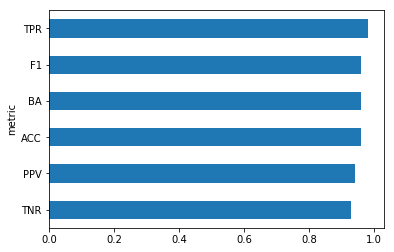

In [60]:
T2.T.sort_values('score').plot.barh(legend=False)

## Compare to SciKit Learn

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

In [ ]:
training_tokens = tokens[tokens.training==1]

In [ ]:
M = training_tokens.groupby(['doc_id','term_id']).n.sum().unstack().fillna(0)

In [ ]:
T = testing_tokens.groupby(['doc_id','term_id']).n.sum().unstack().fillna(0)

In [ ]:
common_cols = list(set(T.columns).intersection(set(M.columns)))

In [ ]:
M = M[common_cols]
T = T[common_cols]

In [ ]:
y = training_tokens.reset_index()[['doc_id','doc_label']].drop_duplicates().set_index('doc_id')

In [ ]:
y_hat = nb.fit(M.values, np.ravel(y.values))

In [ ]:
predictions = pd.Series(y_hat.predict(T.values))

In [ ]:
tdocs = testing_tokens.reset_index()[['doc_id','doc_label']]

In [ ]:
tdocs['predictions'] = predictions

In [ ]:
tdocs

## CMs as probs

In [ ]:
CM / CM.sum()

In [ ]:
CM / CM.sum(1)

## Performance Metrics as Probabilities

![](../../lessons/conf_mat.png)

In [ ]:
CM

$P = 1$  
$N = 0$  
$\pi: predicted \in \{0,1\}$  
$\alpha: actual \in \{0,1\}$  
$T: p(\alpha = \pi) = T_0 + T_1$  
$F: p(\alpha \not= \pi) = F_0 + F_1$    
$TP = T_1 = p(\alpha=1, \pi=1)$    
$TN = T_0 = p(\alpha=0, \pi=0)$  
$FP = F_1 = p(\alpha=0, \pi=1)$  
$FN = F_0 = p(\alpha=1, \pi=0)$  

### Sensitivity or Recall:  
$TPR = R(T_1) = p(\pi=1|\alpha=1)$  

TPR is called sensitivity or recall depending on what it is contrasted with.
- Sensitivty vs. Specificity --> flip values
- Recall vs. Precision --> flip order 

### Specificty:  
$TNR = R(T_0) = p(\pi=0|\alpha=0)$  

### Precision:  
$PPV = p(\alpha=1|\pi=1)$

### Accuracy:  
$ACC = \dfrac{T}{T + F} = \dfrac{p(\alpha = \pi)}{p(\alpha=\pi) + p(\alpha\not=\pi)}$

### Balanced Accuracy:  
$BA = \dfrac{R(T_0)+R(T_1)}{2} = \dfrac{p(\pi=0|\alpha=0) + p(\pi=1|\alpha=1)}{2}$

### F1:  
$F1 = \dfrac{2T_1}{2T_0 + F} = \dfrac{2T_1}{2T_0 + F_1 + F_0}$

## Compute MI 

In [ ]:
term_priors = tokens.loc[tokens.training==1].groupby('term_id').n.count().to_frame()
term_priors = term_priors / term_priors.sum()

In [ ]:
term_priors.head()

In [ ]:
def estimate_mi(row):
    term_id = row.name
    pt = term_priors.loc[term_id]
    a = row.A * log(row.A / (class_priors.loc['A'] * pt))
    b = row.B * log(row.B / (class_priors.loc['B'] * pt))
    return pd.Series((a[0],b[0]))
MI = class_likelihoods.apply(estimate_mi, 1)

In [ ]:
MI.columns = ['A','B']

In [ ]:
MI['term_str'] = vocab.term_str

In [ ]:
MI.sort_values('A', ascending=False).head(10)

In [ ]:
MI.sort_values('B', ascending=False).head(10)

In [ ]:
MI.describe().T

In [ ]:
VA = MI[MI.A > 0.000080].sort_values('A', ascending=False)['term_str'].head(1000)

In [ ]:
VB = MI[MI.B > 0.000085].sort_values('B', ascending=False)['term_str'].head(1000)

In [ ]:
VA